In [ ]:
<p style="font-size:20px">L_H & L_He in F4, F5, and F13</p>

In [1]:

import time
import nugridpy.utils as utils
from ppmpy.ppm import *
import numpy as np
import matplotlib.pyplot as pl
%matplotlib nbagg
import nugridpy.astronomy as ast
%load_ext autoreload
%autoreload 2
'''
#header from ppm.py
from numpy import *
import numpy as np
from math import *
import utils
import matplotlib.pylab as pyl
import matplotlib.pyplot as pl
import os
import re
import astronomy as ast
import scipy.interpolate as interpolate
from scipy import optimize
import copy
import rprofile as rprofile
'''

'\n#header from ppm.py\nfrom numpy import *\nimport numpy as np\nfrom math import *\nimport utils\nimport matplotlib.pylab as pyl\nimport matplotlib.pyplot as pl\nimport os\nimport re\nimport astronomy as ast\nimport scipy.interpolate as interpolate\nfrom scipy import optimize\nimport copy\nimport rprofile as rprofile\n'

In [10]:
yprof = yprofile('/data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/F5')
airmu = 1.39165;cldmu = 0.725
fkair = 0.203606102635;fkcld = 0.885906040268
AtomicNoair = 6.65742024965
AtomicNocld = 1.34228187919
p = yprof.get('L_C12pg', fname = 1,
                                resolution = 'l', airmu = airmu, cldmu = cldmu,
                                fkair = fkair, fkcld = fkcld,  AtomicNoair = AtomicNoair,
                                AtomicNocld = AtomicNocld, corr_fact = 1.5)
print p
yprof.hattrs

Reading attributes from file  YProfile-01-1169.bobaaa
Analyzing headers ...
There are 1170 YProfile files in the /data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/F5 directory.
Ndump values range from 0 to 1169
Time values range from 86.5493 to 101263.0
4.05467322293e-08


{'At base of the convection zone R': '1.11826E+01',
 'At base of the convection zone g': '6.45977E-01',
 'At base of the convection zone p': '4.92879E+00',
 'At base of the convection zone rho': '2.56417E+00',
 'Gravity turns off between radii High': '3.35000E+01',
 'Gravity turns off between radii Low': '3.30000E+01',
 'Gravity turns on between radii High': '8.00000E+00',
 'Gravity turns on between radii Low': '7.00000E+00',
 'Ncycle': '3641040',
 'Ndump': '1170',
 'Rmax': '3.4000E+01 Mmeters',
 'Stellar Conv. Luminosity': '2.98384E-03 x 10^43 ergs,',
 'Thickness (Mm) of heating shell': '2.00000E+00',
 'Thickness (Mm) of transition from convection to stability ': '2.00000E+00  at R =  2.90093E+01 Mm.',
 'Time = High': '1.68771E+03 min.',
 'Time = Low': '1.01263E+05 sec.',
 'courmx': '7.62784E-01',
 'dt': '2.78115E-02',
 'gridX': '1024',
 'gridY': '1024',
 'gridZ': '1024'}

In [11]:
def L_H_L_He_comparison(cases, ifig=101, airmu = 1.39165, cldmu = 0.725,\
    fkair = 0.203606102635, fkcld = 0.885906040268, AtomicNoair = 6.65742024965,\
    AtomicNocld = 1.34228187919):
    
    yprofs = {}
    res = {}
    
    for case in cases:
        
        try:
            yprofs[case] = yprofile(ppm_path+case)
        except ValueError:
            print "have you set the yprofile filepath using ppm.set_YProf_path?"
        
        r = yprofs[case].get('Y', fname=0, resolution='l')
        res[case] = 2*len(r)
        
    airmu = 1.39165
    cldmu = 0.725
    fkair = 0.203606102635
    fkcld = 0.885906040268
    AtomicNoair = 6.65742024965
    AtomicNocld = 1.34228187919

    cb = utils.colourblind

    patience0 = 5
    patience = 60

    sparse = 1
    dumps = {}
    nd = {}
    t = {}
    L_H = {}
    L_He = 2.25*2.98384E-03

    for this_case in cases:
        print 'Processing {:s}...'.format(this_case)

        dumps[this_case] = np.arange(min(yprofs[case].ndumpDict.keys()),\
           max(yprofs[case].ndumpDict.keys()) + 1, sparse)
        #dumps[this_case] = np.arange(min(yprofs[case].ndumpDict.keys()),\
        #   min(yprofs[case].ndumpDict.keys()) + 10, sparse)
        #n_dumps = len(rp_set.dumps)
        nd[this_case] = len(dumps[this_case])
        t[this_case] = np.zeros(nd[this_case])
        L_H[this_case] = np.zeros(nd[this_case])

        t00 = time.time()
        t0 = t00
        k = 0
        for i in range(nd[this_case]):
            t[this_case][i] = yprofs[this_case].get('t', fname = dumps[this_case][i], \
                              resolution = 'l')[-1]
            L_H[this_case][i] = yprofs[this_case].get('L_C12pg', fname = dumps[this_case][i], \
                                resolution = 'l', airmu = airmu, cldmu = cldmu, \
                                fkair = fkair, fkcld = fkcld,  AtomicNoair = AtomicNoair, \
                                AtomicNocld = AtomicNocld, corr_fact = 1.5)

            t_now = time.time()
            if (t_now - t0 >= patience) or \
               ((t_now - t00 < patience) and (t_now - t00 >= patience0) and (k == 0)):
                time_per_dump = (t_now - t00)/float(i + 1)
                time_remaining = (nd[this_case] - i - 1)*time_per_dump
                print 'Processing will be done in {:.0f} s.'.format(time_remaining)
                t0 = t_now
                k += 1

    pl.close(ifig); pl.figure(ifig)
    pl.axhline((1e43/ast.lsun_erg_s)*L_He, ls = '--', color = cb(4), \
        label = r'L$_\mathrm{He}$')
    
    for this_case in cases:
        lbl = r'{:s} $\left({:d}^3\right)$'.format(this_case, res[this_case])
        pl.semilogy(t[this_case]/60., (1e43/ast.lsun_erg_s)*L_H[this_case], \
            ls = '-', color = cb(cases.index(this_case)), marker= 's', markevery=250/sparse, \
            label = case)
        
    pl.xlabel('t / min')
    pl.ylabel(r'L$_H$ / L$_\odot$')
    pl.legend(loc=0, ncol=2)
    pl.tight_layout()
    pl.savefig('L_H-L_He_F4_F5_F13.pdf')


Reading attributes from file  YProfile-01-0872.bobaaa
Analyzing headers ...
There are 872 YProfile files in the /data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/F13 directory.
Ndump values range from 1 to 872
Time values range from 346.197 to 301884.0
NDump 0 Does not exist in this directory
Reselecting NDump as the largest in the Directory
Which is 872
Processing F13...
Processing will be done in 276 s.
Processing will be done in 269 s.
Processing will be done in 253 s.
Processing will be done in 223 s.
Processing will be done in 188 s.
Processing will be done in 153 s.
Processing will be done in 113 s.
Processing will be done in 70 s.
Processing will be done in 28 s.


<IPython.core.display.Javascript object>


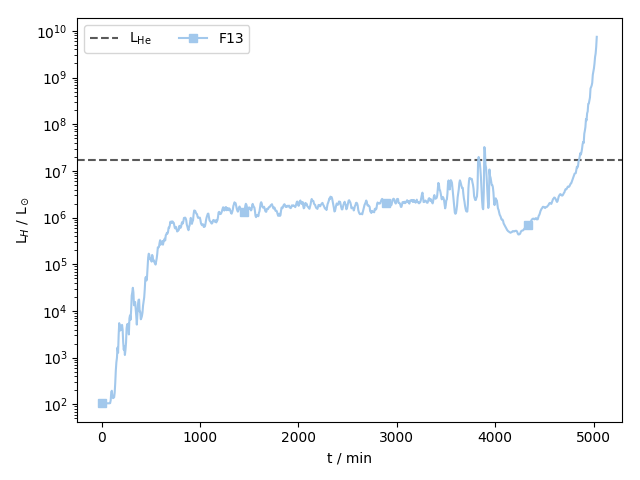

In [3]:
set_YProf_path('/data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/',YProf_fname='YProfile-01-0000.bobaaa')
cases = ['F13']
global ppm_path
ppm_path = '/data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/'

L_H_L_He_comparison(cases)

In [3]:
cases = []
yprof_paths = {}
yprofs = {}
dump_A = {}
dump_B = {}
res = {}
'''
cases.append('F4')
yprof_paths[cases[-1]] = '/data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/F4'
dump_A[cases[-1]] = 0
dump_B[cases[-1]] = 1959

cases.append('F5')
yprof_paths[cases[-1]] = '/data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/F5'
dump_A[cases[-1]] = 0
dump_B[cases[-1]] = 1169
'''
cases.append('F13')
yprof_paths[cases[-1]] = '/data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/F13'
dump_A[cases[-1]] = 1
dump_B[cases[-1]] = 872

for this_case in cases:
    yprofs[this_case] = yprofile(yprof_paths[this_case])
    r = yprofs[this_case].get('Y', fname=0, resolution='l')
    res[this_case] = 2*len(r)

airmu = 1.39165
cldmu = 0.725
fkair = 0.203606102635
fkcld = 0.885906040268
AtomicNoair = 6.65742024965
AtomicNocld = 1.34228187919

cb = utils.colourblind

patience0 = 5
patience = 60

Reading attributes from file  YProfile-01-0872.bobaaa
Analyzing headers ...
There are 872 YProfile files in the /data/ppm_rpod2/YProfiles/AGBTP_M2.0Z1.e-5/F13 directory.
Ndump values range from 1 to 872
Time values range from 346.197 to 301884.0
NDump 0 Does not exist in this directory
Reselecting NDump as the largest in the Directory
Which is 872


In [14]:
sparse = 1
dumps = {}
nd = {}
t = {}
L_H = {}
L_He = 2.25*2.98384E-03

for this_case in cases:
    print 'Processing {:s}...'.format(this_case)
    
    dumps[this_case] = np.arange(dump_A[this_case], dump_B[this_case] + 1, sparse)
    #n_dumps = len(rp_set.dumps)
    nd[this_case] = len(dumps[this_case])
    t[this_case] = np.zeros(nd[this_case])
    L_H[this_case] = np.zeros(nd[this_case])
    
    t00 = time.time()
    t0 = t00
    k = 0
    for i in range(nd[this_case]):
        t[this_case][i] = yprofs[this_case].get('t', fname = dumps[this_case][i], \
                                                resolution = 'l')[-1]
        L_H[this_case][i] = yprofs[this_case].get('L_C12pg', fname = dumps[this_case][i], \
                            resolution = 'l', airmu = airmu, cldmu = cldmu, \
                            fkair = fkair, fkcld = fkcld,  AtomicNoair = AtomicNoair, \
                            AtomicNocld = AtomicNocld, corr_fact = 1.5)

        t_now = time.time()
        if (t_now - t0 >= patience) or \
           ((t_now - t00 < patience) and (t_now - t00 >= patience0) and (k == 0)):
            time_per_dump = (t_now - t00)/float(i + 1)
            time_remaining = (nd[this_case] - i - 1)*time_per_dump
            print 'Processing will be done in {:.0f} s.'.format(time_remaining)
            t0 = t_now
            k += 1

Processing F13...
Processing will be done in 322 s.
Processing will be done in 315 s.
Processing will be done in 299 s.
Processing will be done in 260 s.
Processing will be done in 227 s.
Processing will be done in 186 s.
Processing will be done in 145 s.
Processing will be done in 102 s.
Processing will be done in 60 s.
Processing will be done in 18 s.


<IPython.core.display.Javascript object>


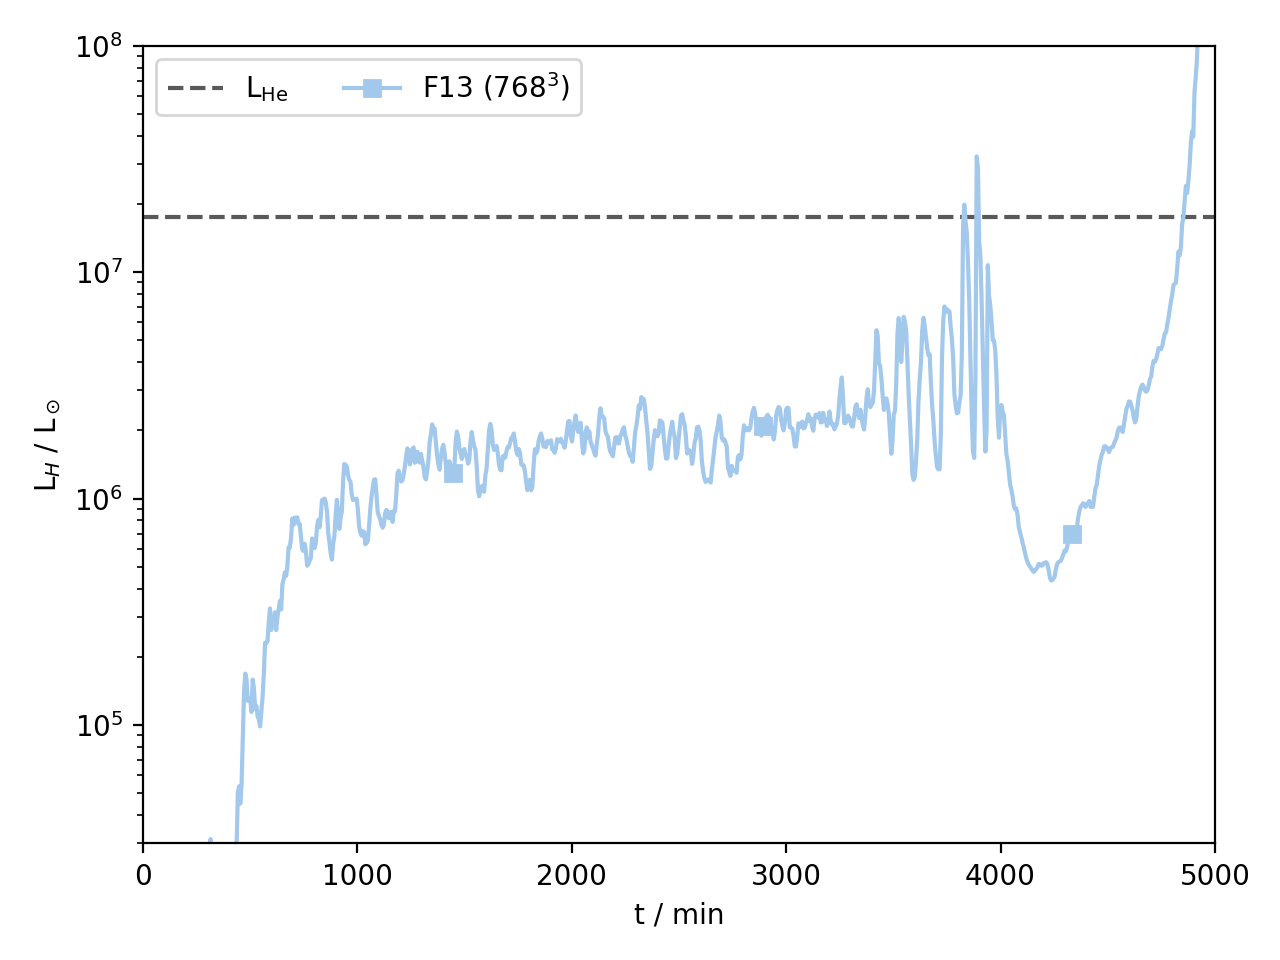

In [16]:
color = [cb(1), cb(0), cb(2)]
zorder = [1, 2, 3]
marker = ['o', 's', '^']

ifig = 1; plt.close(ifig); plt.figure(ifig)
plt.axhline((1e43/ast.lsun_erg_s)*L_He, ls = '--', color = cb(4), \
            label = r'L$_\mathrm{He}$')
'''
k = 0
this_case = 'F4'
lbl = r'{:s} $\left({:d}^3\right)$'.format(this_case, res[this_case])
# The burning was turned on at dump 616, but we want the dotted line to change
# into a solid one inside the plot, where the reader can see it.
idx = np.argmax(dumps[this_case] >= 618)
plt.semilogy(t[this_case][0:idx]/60., (1e43/ast.lsun_erg_s)*L_H[this_case][0:idx], \
             ls = ':', color=color[k], marker=marker[k], markevery=250/sparse, \
             zorder=zorder[k], label='')
plt.semilogy(t[this_case][idx:]/60., (1e43/ast.lsun_erg_s)*L_H[this_case][idx:], \
             color=color[k], marker=marker[k], markevery=250/sparse, \
             zorder=zorder[k], label=lbl)
k += 1

this_case = 'F5'
lbl = r'{:s} $\left({:d}^3\right)$'.format(this_case, res[this_case])
plt.semilogy(t[this_case]/60., (1e43/ast.lsun_erg_s)*L_H[this_case], \
             ls = '-', color=color[k], marker=marker[k], markevery=250/sparse, \
             zorder=zorder[k], label=lbl)
             
'''
k += 1

this_case = 'F13'
lbl = r'{:s} $\left({:d}^3\right)$'.format(this_case, res[this_case])
plt.semilogy(t[this_case]/60., (1e43/ast.lsun_erg_s)*L_H[this_case], \
             ls = '-', color=color[k], marker=marker[k], markevery=250/sparse, \
             zorder=zorder[k], label=lbl)

special_times = np.array([850, 1500, 2103, 2300])
    
plt.xlabel('t / min')
plt.ylabel(r'L$_H$ / L$_\odot$')
plt.xlim((0., 5e3))
plt.ylim((3e4, 1e8))
plt.legend(loc=0, ncol=2)
plt.tight_layout()
plt.savefig('L_H-L_He_F4_F5_F13.pdf')